In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np
import matplotlib.pyplot as plt

dtype = torch.float32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.set_default_tensor_type(torch.cuda.FloatTensor)
to_nearest_64 = lambda x: round(x/64) * 64
model_scale = 1.
max_seq_len = 100

qk_dim_div = 8
expand_factor = 2
residual_depth = to_nearest_64(384 * math.log2(1.+model_scale))

num_blocks = round(8 * math.log2(1.+model_scale))
causal_mask = torch.triu(torch.ones(max_seq_len, max_seq_len), diagonal=1).bool()

n_toks = 100

with torch.no_grad():
  bias_range = torch.arange(-max_seq_len+1, 1).to(device, dtype)
  position_bias_base = bias_range.unsqueeze(0) - bias_range.unsqueeze(1)
  negative_infinity_matrix_base = torch.empty_like(position_bias_base).fill_(-float("inf"))
  causal_mask = torch.tril(torch.ones((max_seq_len, max_seq_len), device=device, dtype=torch.bool))

/home/service/miniconda3/envs/llm_research/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
class LatentAttentionBlock(nn.Module):
  """ Efficient fused latent-space attention block. Linear keys and queries, nonlinear values."""
  def __init__(self, num_dim):
    super().__init__()

    self.dim        = num_dim
    self.qk_dim     = self.dim//qk_dim_div
    self.v_dim      = num_dim
    self.expand_dim = num_dim * expand_factor
    

    self.norm       = nn.LayerNorm(self.dim, bias=False)
    self.expand     = nn.Parameter(.5 * 1./residual_depth**.5 * 1./expand_factor * torch.randn(2*self.qk_dim+2*self.expand_dim, self.dim))
    self.project    = nn.Parameter(1. * 1./residual_depth**.5 * 1./expand_factor * 1./num_blocks * torch.randn((self.dim, self.expand_dim),dtype=dtype))
    self.position_bias_mult = nn.Parameter(torch.tensor(1.))

  def forward(self, x):
  
    residual = x
    attn_mask = torch.where(causal_mask[:x.shape[1], :x.shape[1]], F.softplus(self.position_bias_mult) * position_bias_base[:x.shape[1], :x.shape[1]], negative_infinity_matrix_base[:x.shape[1], :x.shape[1]])
    x = self.norm(x)
    query, key, linear, pre_gelu = F.linear(x, self.expand).split((self.qk_dim, self.qk_dim, self.expand_dim, self.expand_dim), dim=-1)
    geglu = linear * F.gelu(pre_gelu)
    geglu_local, geglu_attention_value = geglu.split((self.expand_dim-self.v_dim, self.v_dim), -1)
    attention = F.scaled_dot_product_attention(query, key, geglu_attention_value, attn_mask=attn_mask)
    out = F.linear(torch.cat([geglu_local, attention], dim=-1), self.project)
    x = residual + out
    return x
  
class LatentCrossAttentionBlock(nn.Module):
  def __init__ (self, num_dim):
    super().__init__()
    
    self.dim        = num_dim
    self.qk_dim     = self.dim//qk_dim_div
    self.v_dim      = num_dim
    self.expand_dim = num_dim * expand_factor
    self.local_dim  = self.expand_dim - self.v_dim
    
    self.norm       = nn.LayerNorm(self.dim, bias=False)
    self.Wq         = nn.Parameter(.5 * 1./residual_depth**.5 * 1./expand_factor * torch.randn(self.qk_dim + 2 * self.local_dim, self.dim))
    self.Wkv        = nn.Parameter(.5 * 1./residual_depth**.5 * 1./expand_factor * torch.randn(self.qk_dim + 2 * self.v_dim, self.dim))
    
    self.project    = nn.Parameter(1. * 1./residual_depth**.5 * 1./expand_factor * 1./num_blocks * torch.randn((self.dim, self.expand_dim),dtype=dtype))

  def forward(self, q, kv):
    residual = q
    q = self.norm(q)
    query, lin_local, pre_geglu_local = F.linear(q, self.Wq).split((self.qk_dim, self.local_dim, self.local_dim), dim=-1)
    geglu_local = lin_local * F.gelu(pre_geglu_local)
    key, lin_value, pre_geglu_value = F.linear(kv, self.Wkv).split((self.qk_dim, self.v_dim, self.v_dim), dim=-1)
    geglu_value = lin_value * F.gelu(pre_geglu_value)
    attention = F.scaled_dot_product_attention(query, key, geglu_value)

    out = F.linear(torch.cat([geglu_local, attention], dim=-1), self.project)
    return residual + out    


class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.emb = nn.Embedding(n_toks, residual_depth, scale_grad_by_freq=True)
    self.pt_emb = nn.Embedding(n_toks, residual_depth//2, scale_grad_by_freq=True)
    self.blocks = nn.ModuleList([LatentAttentionBlock(residual_depth) for _ in range(num_blocks)])
    self.blocks2 = nn.ModuleList([LatentCrossAttentionBlock(residual_depth) for _ in range(num_blocks)])
    self.norm = nn.LayerNorm(residual_depth, bias=False)
    self.out = nn.Linear(residual_depth, n_toks, bias=False)
  
  def forward(self, q:torch.Tensor, pts:torch.Tensor):
    q = self.emb(q)

    kv = self.pt_emb(pts) # B, 100, 2, D / 2
    kv = kv.view(kv.shape[0], -1, residual_depth) # B, 100 , D
    
    q = self.norm(q)
    for block, block2 in zip(self.blocks, self.blocks2):
      q = block(q)
      q = block2(q, kv)
    q = self.norm(q)
    q = self.out(q)
    return q

net = Model().to(device, dtype).train()
opt = optim.Adam(net.parameters(), lr=3e-4)



def random_shape():
  n = np.random.randint(3, 10)
  corners = []
  for i in range(n):
    angle = 2*np.pi*i/n + np.random.rand()*0.1
    r = np.random.rand() * 0.5 + 0.5
    corners.append(torch.tensor([np.cos(angle)*r, np.sin(angle)*r],dtype=torch.float32))
  verts = []
  corner_dir = np.random.randint(2)
  for i in range(n + 1):
    verts.append(corners[i % n])
    verts.append(torch.tensor([corners[(i+corner_dir) % n][0] , corners[(i + 1 - corner_dir) % n][1]]))

  verts = torch.stack(verts[:-1])
  return verts

def pointcloud(verts,n ):
  edges = torch.cat([verts, verts.roll(-1, 0)], dim=1)
  edge_lens = torch.linalg.norm(edges[:,2:] - edges[:,:2], dim=1)
  rand_edges = edges[torch.multinomial(edge_lens / edge_lens.max(), n, replacement=True)]
  points = rand_edges[:, :2] + torch.rand((n,1)).reshape(-1,1) * (rand_edges[:, 2:] - rand_edges[:, :2])
  return points +torch.randn(n, 2) * 0.01

/home/service/miniconda3/envs/llm_research/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
max_points = 19

def display(s):
  s = s[:2 * max_points]
  s = s.reshape(-1,2)
  while (s[-1]==49).sum() == 2: s = s[:-1]
  plt.plot(s[:,0].cpu().numpy(), s[:,1].cpu().numpy())

def gen_data(n):
  shapes = [random_shape() for _ in range(n)]
  pts = torch.stack([pointcloud(s, 100) for s in shapes])
  x = torch.stack([torch.cat([s, torch.zeros(max_points - len(s), 2)]) for s in shapes])
  x = x.view(n, -1)
  x = (x + 1) / 2 * (n_toks-1)
  x = x.long()
  pts = (pts + 1) / 2 * (n_toks-1)
  pts = pts.clamp(0, n_toks-1)
  pts = pts.long()
  pad = torch.zeros(n, 1).long()
  y = x
  x = torch.cat([pad, x], dim=1)[:, :-1]
  return x, y, pts

In [4]:
def step(x,y,pts):
  opt.zero_grad()
  out = net(x,pts)
  loss = F.cross_entropy(out.reshape(-1, n_toks),y.flatten())
  loss.backward()
  opt.step()
  return loss

In [5]:
opt.param_groups[0]['lr'] = 3e-6

In [8]:
from torch.optim.lr_scheduler import StepLR

net = Model().to(device, dtype).train()
opt = optim.Adam(net.parameters(), lr=3e-4)

epochs = 5_000
opt.param_groups[0]['lr'] = 3e-4

scheduler = StepLR(opt, step_size=epochs//40, gamma=0.9)
for e in range(epochs):
  if e % 10 == 0: x, y, pts = gen_data(100)
  loss = step(x, y, pts)
  if e % (epochs // 100) == 0: print(loss.item(), flush=True)
  scheduler.step()

4.432274341583252
2.263408660888672
1.7521003484725952
1.409633994102478
1.114113688468933
0.9385735392570496
0.7599945664405823
0.7152401208877563
0.6441329121589661
0.5985929369926453
0.6010657548904419
0.4841998815536499
0.4616208076477051
0.46506354212760925
0.43523114919662476
0.4381576478481293
0.44077929854393005
0.4070216417312622
0.45223575830459595
0.4178932309150696
0.41055646538734436
0.390625536441803
0.3317536413669586
0.39460593461990356
0.3557986915111542
0.3698878288269043
0.337239146232605
0.31966933608055115
0.34668102860450745
0.25864654779434204
0.3071669936180115
0.32059696316719055
0.3064340353012085
0.30588459968566895
0.306631863117218
0.28843024373054504
0.28647300601005554
0.2970140278339386
0.2964429557323456
0.3086284399032593
0.3101615905761719
0.3098485469818115
0.2825368046760559
0.2975679934024811
0.28386905789375305
0.28782573342323303
0.3005917966365814
0.2697649896144867
0.28879356384277344
0.2789590358734131
0.2660149037837982
0.2659926116466522
0.2

******* INFERENCE ********


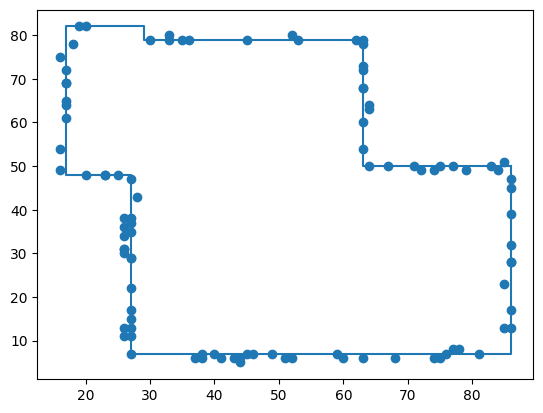

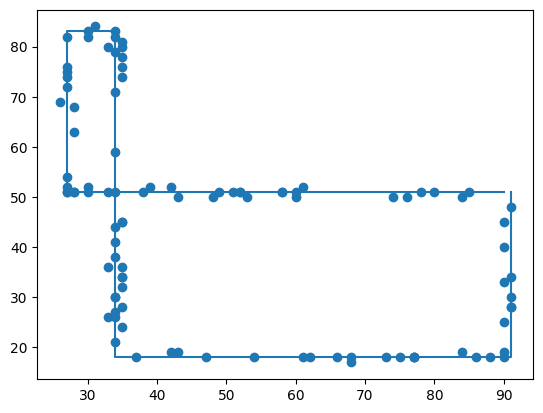

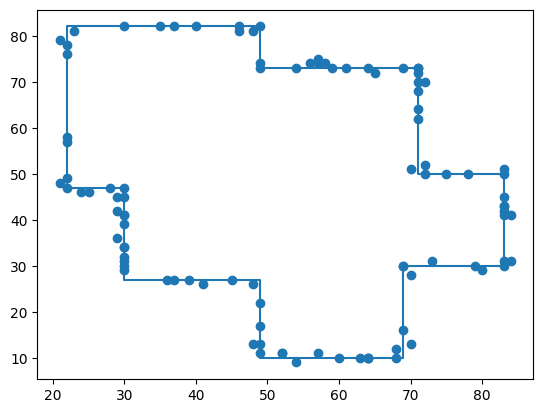

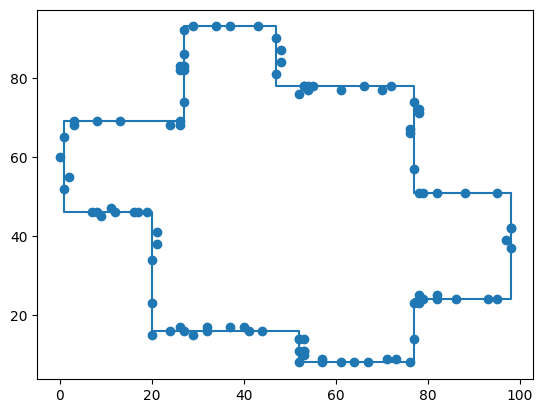

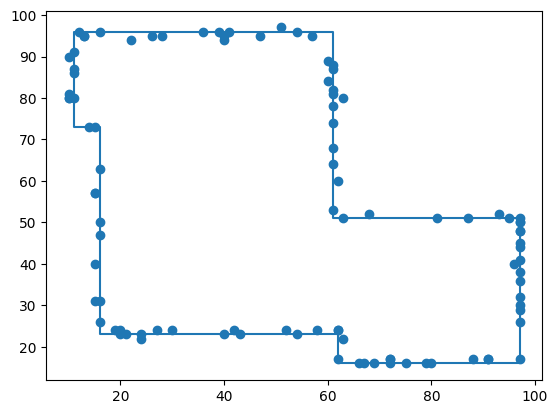

In [9]:
print ("******* INFERENCE ********")

def generate(n):
  x = torch.zeros(1, 1).long()
  _,_,pts = gen_data(1)
  for i in range(n):
    p = net(x[:,-99:], pts)
    choices = p[0,-1,:]
    # choice = torch.multinomial(choices.softmax(-1), 1)
    choice = choices.argmax(-1)
    x = torch.cat([x, choice.reshape(1,1)], dim=1)
  return x,pts

for i in range(5):
  p,pts = generate(max_points*2)
  plt.scatter(pts[0,:,0].cpu().numpy(), pts[0,:,1].cpu().numpy())
  display(p[0,1:])
  plt.show()